# A larger Example

In this we will be looking at a actual dataset from Kaggle [medical_insurance](https://www.kaggle.com/datasets/mirichoi0218/insurance) and try to figure out the regression model.

In [16]:
# default import

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [17]:
# get the dataset
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")
insurance.head()



,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## One hot Encoding

Use pandas get_dummies function to do the job...
pass in `dtype=int` to have 0 and 1 instead of true and false

In [18]:
insurance_one_hot = pd.get_dummies(insurance, dtype=int)
insurance_one_hot.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


In [19]:
# Create X & y values (Feature and labels)

X = insurance_one_hot.drop("charges", axis=1)
y = insurance_one_hot["charges"]

# view X and y
X.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,1,0,0,1,0,0,0,1
1,18,33.770,1,0,1,1,0,0,0,1,0
2,28,33.000,3,0,1,1,0,0,0,1,0
3,33,22.705,0,0,1,1,0,0,1,0,0
4,32,28.880,0,0,1,1,0,0,1,0,0


In [20]:
y.head()

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

In [21]:
# Create training and test case

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X), len(X_test), len(X_train)


(1338, 268, 1070)

In [22]:

tf.random.set_seed(42)

#Build a neural network
insurance_model = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(1)
], name="insurance_model")

# 2) compile the model

insurance_model.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=["mae"]
)

# 3 fit the model
history = insurance_model.fit(X_train, y_train, epochs=100, verbose=0)

Text(0.5, 0, 'epoch')

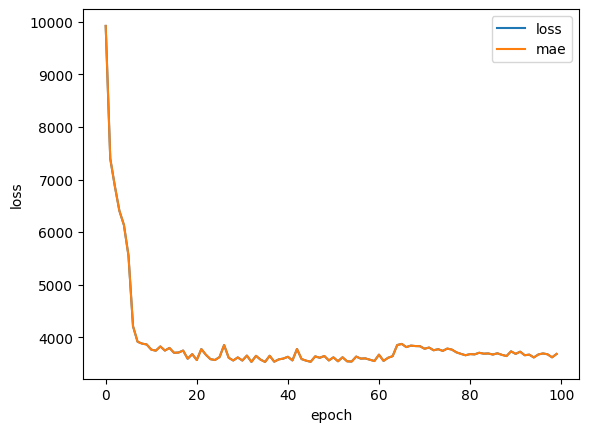

In [23]:
# plot history, also know as a loss curve of training curve

pd.DataFrame(history.history).plot()

plt.ylabel("loss")
plt.xlabel("epoch")

> **Question:** How long should you train for?

It depends. Really... It depends on the problem you are working on. This is one of the most important question asked while training the model.
Tensorflow has a solution, its called `Early stopping callback` which is Tensorflow component you can add to model to stop training on improving a certain metrix

> What is Normalization in machine learning?

Normalization is a technique often applied as part of data preparation for machine learning. The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting difference in the ranges of values. For machine learning, every dataset does not required normalization

## Preprocessing Data (normalization and standardization)

In terms of scaling values, neural network tends to prefer normalization.

If not sure what ot use, you can try both

In [31]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")
insurance.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [25]:
# Create a column transformer

from matplotlib import axis


ct = make_column_transformer(
    (MinMaxScaler(), ["age", "bmi", "children"]), # turn all value in this columns between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), ["sex", "smoker", "region"])
)

X = insurance.drop("charges", axis=1)
y = insurance["charges"]

# build our train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit column transformer to training data
ct.fit(X_train)

# transform training and test data
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)


In [26]:
# what does our data look like?

X_train.loc[0]

age                19
sex            female
bmi              27.9
children            0
smoker            yes
region      southwest
Name: 0, dtype: object

In [27]:
X_train_normal[0]

array([0.60869565, 0.10734463, 0.4       , 1.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        ])

In [28]:
# build a neural network model to fit on our normalize data
tf.random.set_seed(42)

# 1) Create a model
insurance_model_improved = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

# 2) Compile the model
insurance_model_improved.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=["mae"]
)

# 3) Fit the model
model_history = insurance_model_improved.fit(X_train_normal, y_train, epochs=100)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 13252.6367 - mae: 13252.6367 
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 12055.2314 - mae: 12055.2314
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 8358.2246 - mae: 8358.2246
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 7573.6792 - mae: 7573.6792
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 7106.2773 - mae: 7106.2773
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 6490.6187 - mae: 6490.6187
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 5577.0273 - mae: 5577.0273
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 4387.9341 - mae: 4387.9341
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 3689.8945 - mae: 3689.8945
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 3643.6609 - mae: 3643.6609
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 3622.5620 - mae: 3622.5620
Epoch 12/100
34/34 ━━━━━━

In [29]:
# evaluate the model on normal data
insurance_model_improved.evaluate(X_test_normal, y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 3219.6396 - mae: 3219.6396


[3166.84423828125, 3166.84423828125]

Text(0.5, 0, 'epochs')

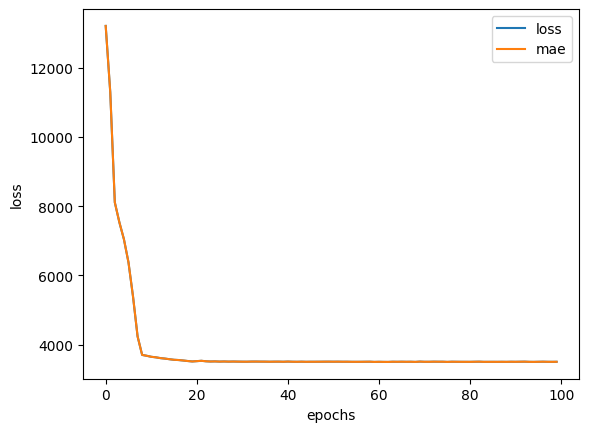

In [30]:
# 4) Check the curve
pd.DataFrame(model_history.history).plot()

plt.ylabel("loss")
plt.xlabel("epochs")